In [1]:
%matplotlib inline
# %matplotlib notebook # Does not work 
import pickle 
import numpy as np
from matplotlib import pyplot as plt
import json
from hpbandster.core.result import logged_results_to_HBS_result
from matplotlib.backends.backend_pdf import PdfPages
from datetime import datetime
import os

In [2]:
def open_hpo_results_files(file):
    with open(file, 'rt') as f_in:
        raw = []
        for line in f_in:
            raw.append(json.loads(line))
        return raw

In [3]:
def load_hpo_results(results_dir):
    results_file = results_dir + 'results.json'
    config_file = results_dir + 'configs.json'
    return {
        'results_lines': open_hpo_results_files(results_file),
        'config_lines': open_hpo_results_files(config_file)        
        }

In [4]:
def load_results(file):
    with open(file, 'rt') as f_in:
        results = []
        for line in f_in:
#             line = line.strip('\n')
            results.append(json.loads(line))
    
#         if not results:
#             return
        
        if 's1' in results[0][3]['info'].keys():
            fold = 's1'
        else: 
            fold = 's'
        out_dict = {'loss_data': [x[3]['loss'] for x in results if x[1] == 100], # Get only runs on 100% of data
#         return {'loss_data': [x[3]['loss'] for x in results], # Get only runs on 100% of data
#                 'dataset': 'tvqa',
#                 'hpo_method': file.split('/')[-2].split('_')[2],
                'times': [x[2] for x in results if x[1] == 100],
                'model_file': [x[3]['info'][fold]['info']['model_file'] for x in results if x[1] == 100],
                'file': file
               }
#         print(results[0][3]['info'].keys())
        if 'mean_metric_test' in results[0][3]['info'].keys():
            if 'tvqa' in file.lower():
                out_dict['test_results'] = [x[3]['info'][fold]['info']['test_results'] for x in results if x[1] == 100]
            else:
                out_dict['test_results'] = [x[3]['info']['mean_metric_test'] for x in results if x[1] == 100]
#             print(out_dict['test_results'][0:10])
                
    return out_dict

In [5]:
def get_hpo_results_dir(workdir, hpo_method):
    
    results_dirs = []
    for root, dirs, files in os.walk(workdir, topdown=False):
        for name in dirs:
            if (hpo_method in name):
                results_dirs.append(os.path.join(root, name))
    return results_dirs

In [6]:
def plot_results(dataset, hpo_method, *plots, dev_def=0, test_def=0, n=0, n_lim=0, time_flag=False, raw_flag=False):

    
    
    plt.figure(num=None, figsize=(12, 5), dpi=80, facecolor='w', edgecolor='k')
    plt.clf()

    plt.title(dataset.upper() + ' HPO validation set' )
    
    dev_line = plt.axhline(y=dev_def, color='r', linestyle='--', label = 'Val default hp')
    
    
    signals = []
    for plot_data in plots:
        plot_id = plot_data['file'].split('/')[-2]
        len_data = len(plot_data['loss_data'])
        
        if (n_lim < len_data) and (n_lim > 0):
            n_up = n_lim
        else:
            n_up = len_data
        
        

        
        pp = PdfPages(dataset + '_hpo_curve.pdf')
        pp.savefig()
#         y_results = [1 - min(plot_data['loss_data'][0:i+1]) for i,x in enumerate(plot_data['loss_data'])]
        y_results = [1 - min(plot_data['loss_data'][0:i+1]) for i,x in enumerate(plot_data['loss_data'])]
        
        inverse_loss = [1 - x for x in plot_data['loss_data']]
    
        if time_flag:
            initial = plot_data['times'][0]['submitted']
#             time_diff = plot_data['times'][-1]['finished'] - 
#             idx = list(np.linspace(0, time_diff, num=len(metric_max_avg)))
            idx = [x['finished'] - initial for x in plot_data['times']]
        
            idx = [x/3600 for x in idx]
            plt.xlabel('wallclock-time [hr]', fontsize = 13)
            
            
        else:
            idx = list(range(0,len(y_results)))
            plt.xlabel('# function evaluations', fontsize = 13)
            
        
        if dataset == 'tvqa':            
            plt.ylabel('Loss/Accuracy', fontsize = 13)
        else:
            plt.ylabel('Loss/MAP', fontsize = 13)
            
#         print('n_up: ', n_up, len(idx[n:n_up]))
        
        p = plt.plot(idx[n:n_up], y_results[n:n_up], label = hpo_method.upper() + '_'+ plot_id)
        
#         print(p[0].get_color())

        duration = plot_data['times'][n_up-1]['finished'] - plot_data['times'][0]['submitted']
        print('Duration! -see comment in code: ', round(duration/3600,2), # Careful: I concatenated results from different run dates!
              'hrs', 'plot_id: ', plot_id,
              'Length: ', n_up)    
        
        if 'test_results' in plot_data.keys():
            print('yes, test data!')
#             test_y = [max(plot_data['test_results'][0:i+1]) for i,x in enumerate(plot_data['test_results'])]
            test_y = plot_data['test_results']
            plt.axhline(y=test_def, color='r', linestyle='--', label = 'Test default hp')
            plt.plot(idx[n:n_up], test_y[n:n_up], linestyle='--', color=p[0].get_color(),  label = 'Test_' + plot_id)
            
            
            min_val = min(plot_data['loss_data'])
            idx_min = plot_data['loss_data'].index(min_val)             
            min_val_config = plot_data['model_file'][idx_min]
            print('Max val config!: ', min_val_config, '; Max val value: ', 1 - min_val)
            
            max_test = max(plot_data['test_results'])
            idx_max = plot_data['test_results'].index(max_test)             
            max_test_config = plot_data['model_file'][idx_max]
            print('Max test config!: ', max_test_config, '; Max test value: ', max_test)
            
        
        
        if raw_flag:
            plt.plot(idx[n:n_up], inverse_loss[n:n_up], label = 'Raw '+ hpo_method.upper(), color=p[0].get_color(), alpha=0.3)
        
        signals.append([y_results[n:n_up], idx[n:n_up]])
#     plt.plot([x/hour for x in incumbent_bohb['times_finished']], incumbent_bohb['losses'])
    pp.savefig()
    plt.legend()
    plt.show()
    pp.close()
    return signals

In [7]:
def get_best_config(*results_dirs):
    
    for results_dir in results_dirs:
        results = logged_results_to_HBS_result(results_dir)
        print( {'dir': results_dir,
                'config': results.get_id2config_mapping()[results.get_incumbent_id()]['config'],
                'mean_metric': results.get_runs_by_id(results.get_incumbent_id())[-1].info['mean_metric']
               }, '\n' )



###############################
####### New Graph #############

Duration! -see comment in code:  40.54 hrs plot_id:  hpo_results_bohb Length:  1074
Duration! -see comment in code:  25.96 hrs plot_id:  hpo_results_bohb_1573636293 Length:  1500
Duration! -see comment in code:  17.04 hrs plot_id:  hpo_results_bohb_1573758626 Length:  869
Duration! -see comment in code:  29.21 hrs plot_id:  hpo_results_bohb_1573820947 Length:  870
Duration! -see comment in code:  21.66 hrs plot_id:  hpo_results_bohb_1573848102 Length:  962
Duration! -see comment in code:  8.5 hrs plot_id:  hpo_results_bohb_1574032883 Length:  443


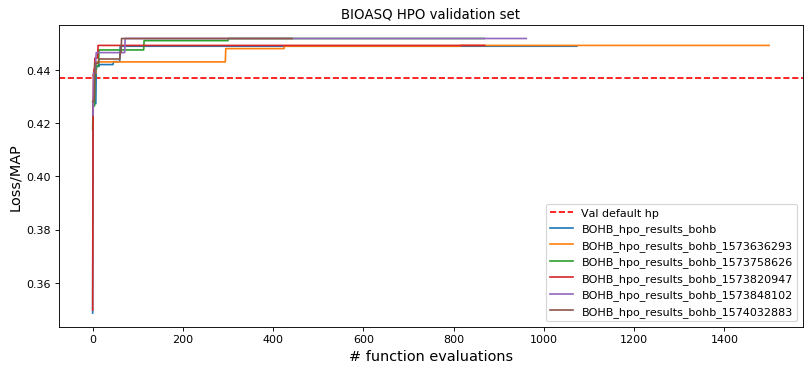



###############################
####### New Graph #############

yes, there are results!
Duration! -see comment in code:  18.78 hrs plot_id:  hpo_results_rs_1573636254 Length:  1000
Duration! -see comment in code:  17.37 hrs plot_id:  hpo_results_rs Length:  1000
Duration! -see comment in code:  15.04 hrs plot_id:  hpo_results_rs_1573820144 Length:  1000
Duration! -see comment in code:  13.22 hrs plot_id:  hpo_results_rs_1573848109 Length:  1000
Duration! -see comment in code:  0.84 hrs plot_id:  hpo_results_rs_1574106905 Length:  66


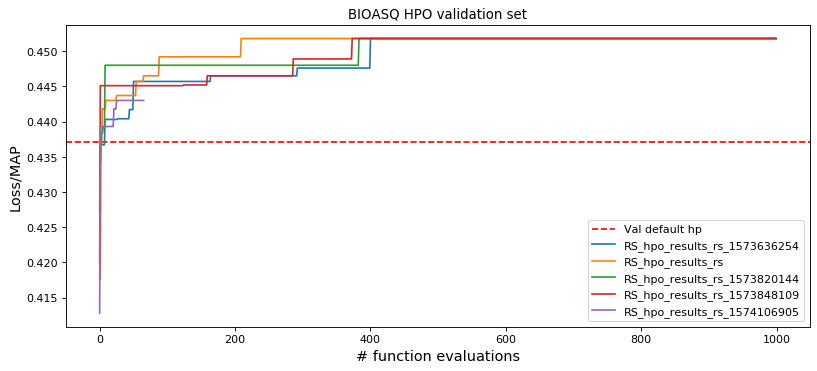



###############################
####### New Graph #############

Duration! -see comment in code:  22.53 hrs plot_id:  hpo_results_bohb_1573765824 Length:  186
Duration! -see comment in code:  40.47 hrs plot_id:  hpo_results_bohb Length:  298
Duration! -see comment in code:  22.43 hrs plot_id:  hpo_results_bohb_1573636384 Length:  131
Duration! -see comment in code:  74.19 hrs plot_id:  hpo_results_bohb_1573718146 Length:  177
Duration! -see comment in code:  17.71 hrs plot_id:  hpo_results_bohb_1574004561 Length:  108


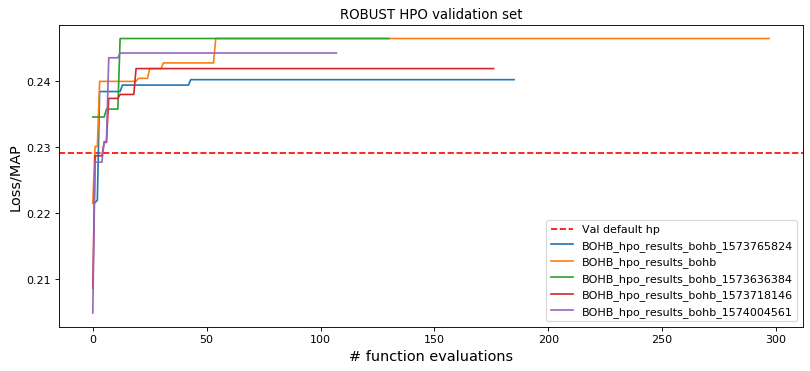



###############################
####### New Graph #############

Duration! -see comment in code:  22.64 hrs plot_id:  hpo_results_rs_1573636396 Length:  272
Duration! -see comment in code:  65.3 hrs plot_id:  hpo_results_rs_1573718156 Length:  227
Duration! -see comment in code:  13.59 hrs plot_id:  hpo_results_rs_1573954581 Length:  173
Duration! -see comment in code:  40.55 hrs plot_id:  hpo_results_rs Length:  499
Duration! -see comment in code:  22.81 hrs plot_id:  hpo_results_rs_1573765785 Length:  291


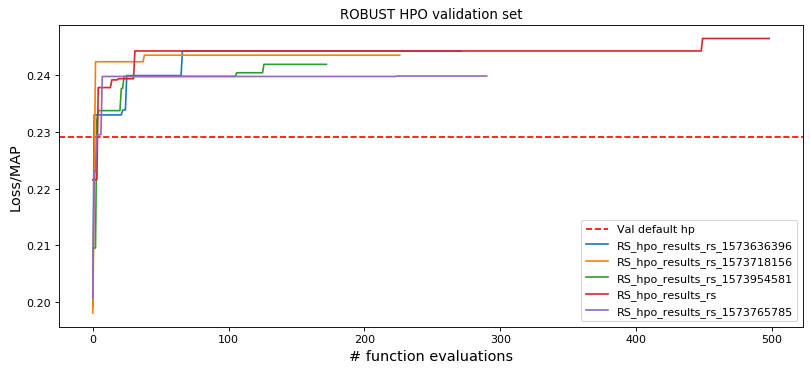



###############################
####### New Graph #############



IndexError: list index out of range

In [8]:
# For each dataset and hpo method


workdirs = [ 
            './deep-relevance-ranking/models/baselines/bioasq_dir/',
            './deep-relevance-ranking/models/baselines/robust_dir/',
            './TVQA/workdir/'
           ]
dev_defaults = [
                0.4371,
                0.2292,
                0.55597
               ]

test_defaults = [
                0.4703,
                0.2189,
                0.56291
               ]

hpo_methods = [
                'bohb', 
                'rs'
]

# adjust_min=True
adjust_min=False
n_limit = 0

only_test_flag = False
# only_test_flag = True

for wdir, dev_def, test_def in zip(workdirs, dev_defaults, test_defaults):
    for hpo_m in hpo_methods:
        print('\n\n###############################\n####### New Graph #############\n')
        # Get results_dir
        results_dirs = get_hpo_results_dir(wdir, hpo_m)

#         print(results_dirs)
        # Get mean, std
        results_files = [x + '/results.json' for x in results_dirs]

        if 'bioasq' in wdir.lower():
            dataset = 'bioasq'
        elif 'robust' in wdir.lower():
            dataset = 'robust'
        elif 'TVQA'.lower() in wdir.lower():
            dataset = 'tvqa'
        
#         print(dataset)
#         avg_res = get_avg_results(results_files)
        res_hpo = []
        for r in results_files:
            r_hpo = load_results(r)
#             print('estas claves', list(r_hpo.keys()))
#             if only_test_flag:                
            if 'test_results' in r_hpo.keys():
                print('yes, there are results!')
#                 res_hpo.append(r_hpo)
            else:
                res_hpo.append(r_hpo)
        
        if not res_hpo:
            continue
        if adjust_min:
            n_limit = min(len(r['loss_data']) for r in res_hpo)
            print(n_limit)
            
#         n_limit = 800
        
        signals = plot_results(dataset, hpo_m, *res_hpo, dev_def=dev_def, test_def=test_def, n=0, n_lim=n_limit, time_flag=False, raw_flag=False)
        
        

        # Plot

        # Save results all results

In [ ]:
# plot_results(rob_bohb_results, rob_rs_results,  default=0.2292, n=0, time_flag=True, raw_flag=True)
# plot_results(bio_bohb_results,bio_rs_results , default=0.4371, n=0, n_lim=0, time_flag=True)

In [ ]:
# now = datetime.now()
# timestamp = datetime.timestamp(now)

# tvqa_bohb_dir = tvqa_bohb_file.replace('results.json','')
# tvqa_rs_dir = tvqa_rs_file.replace('results.json','')

# analyzed_results = {'tvqa_bohb': load_hpo_results(tvqa_bohb_dir),
#                     'tvqa_rs': load_hpo_results(tvqa_rs_dir)
#                     }

# analyzed_results_file = './tvqa_hpo_results_' + str(timestamp) + '.pkl'


In [ ]:
# pickle.dump( analyzed_results, open(analyzed_results_file, 'wb'))

# loaded_results = pickle.load( open( analyzed_results_file, "rb" ))
# for k in loaded_results.keys():
#     print(loaded_results[k]['results_lines'][0], '\n')

In [ ]:
# get_best_config(tvqa_bohb_dir, tvqa_rs_dir)